In [1]:
from IPython.display import Markdown as md
import os
import numpy as np
import matplotlib.pyplot as plt
import ssl
import pandas as pd
import os
from datetime import datetime
ssl._create_default_https_context = ssl._create_unverified_context

COUNTRY = os.getenv('NB_ARGS', 'China')
if COUNTRY is None:
    raise RuntimeError("No country is provided by the user! NOT running!") 
md(f"# Web-based Analysis of Spread of Covid-19 for country {COUNTRY}")

# Web-based Analysis of Spread of Covid-19 for country China

## Introduction

Based on Reference [1], an SIR (the Spread of an Infective Disease) model for infective disease is based on the following differential equations.

${dS \over dt} = -{\beta I S \over N}$

${dI \over dt} = {\beta I S \over N} - {\gamma I}$

${dR \over dt} = {\gamma I}$

where
* $S$ is the initial susceptible population
* $I$ is the initial infected population
* $R$ is the initial recovered population
* $N$ is the initial sum of $S$, $I$, $R$ and will remain constants

due to the observation that

${dS \over dt}+{dI \over dt}+{dR \over dt}=0$

$\beta$ and $\gamma$ are directly related to the basic reproduction number
$R_0$ and typical time until recovery $T_r$ in the following formula:

$R_0={\beta \over \gamma}$

$T_r = {\gamma}^{-1}$

The SIR model lies on a few assumptions:
* $R_0$ and $T_r$ is constant through the whole simulation process.
* There is no/few deaths from the disease so that $N$ is constant through the process.
* Recovered population will get immune to the spread of the disease.

# Methods (Implementations of SIR model)
The model is implemented and tested based on finite difference represetation of the above differential equations. Specifically, the three core finite difference equations are listed below: 

$S^{t+\Delta t} \approx S^{t}-{\beta I^{t} S^{t} \over N}\Delta t$

$I^{t+\Delta t} \approx I^{t}+({\beta I^{t} S^{t} \over N} - \gamma I^{t})\Delta t$

$R^{t+\Delta t} \approx R^{t}+ \gamma I^t\Delta t$

Therefore, I can implement the iterative algorithm based on the initial values of $s_0$, $i_0$, $r_0$ and parameters $\beta$ and $\gamma$ similar to Reference [2].


In [2]:
# based on old values, calculate new values for time change dt
def s_new(s_old, i_old, beta, n, dt):
    """
    Computes S value for the next timestep, based on
    s_old : current S value
    i_old : current I value
    beta : R0 * gamma
    n: sum of S, I and R, which is constant through the whole time
    dt : timestep
    """
    return s_old - beta * i_old * s_old / n * dt

def i_new(s_old, i_old, beta, gamma, n, dt):

    """
    Computes I value for the next timestep, based on
    i_old : current I value
    s_old : current S value
    beta : R0 * gamma
    gamma : inverse of Tr (typical time until recovery)
    n: sum of S, I and R, which is constant through the whole time
    dt : timestep
    """
    return i_old + (beta * i_old * s_old / n - gamma * i_old) * dt

def r_new(i_old, r_old, gamma, dt):
    """
    Computes R value for the next timestep, based on
    i_old : current I value
    s_old : current R value
    gamma : inverse of Tr (typical time until recovery)
    dt : timestep
    """
    return r_old + gamma * i_old * dt


# Solve the problem with iterations.
def sor_model(s_0, i_0, r_0, beta, gamma, t_n, dt):
    """
    s_0, i_0, r_0 : initial values for s, i, r
    beta : R0 * gamma
    gamma : inverse of Tr (typical time until recovery)
    t_n : final time step
    dt : timestep
    Returns four numpy arrays, s, i, r, t.
    """
  
    # Calculate # of timesteps and prepare result t array.
    num_timesteps = int(t_n / dt) + 1
    t = np.arange(start=0.0, stop=t_n+dt, step=dt)

    # Initialize result arrays.
    s = np.zeros(num_timesteps, dtype=float)
    i = np.zeros(num_timesteps, dtype=float)
    r = np.zeros(num_timesteps, dtype=float)

    # Store the initial SIR populations.
    s[0] = s_0
    i[0] = i_0
    r[0] = r_0
    n = s_0 + i_0 + r_0

    # Iterate!
    for iter in np.arange(1, num_timesteps):
        s[iter] = s_new(s_old=s[iter-1], i_old=i[iter-1], beta=beta,
                        n=n, dt=dt)
        i[iter] = i_new(s_old=s[iter-1], i_old=i[iter-1], beta=beta,
                        gamma=gamma, n=n, dt=dt)
        r[iter] = r_new(i_old=i[iter-1], r_old=r[iter-1], gamma=gamma, dt=dt)
    return s, i, r, t

def plot_series(t, series_list, series_labels, 
                xlabel, ylabel, title):
    """
    series_list : list of numpy results to plot
    series_labels : list of labels for above series_list
    xlabel, ylabel : label for x and y axes respectiely
    title : plot title
    """
    for series, label in zip(series_list, series_labels):
      plt.plot(t, series, label=label)
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

<AxesSubplot:>

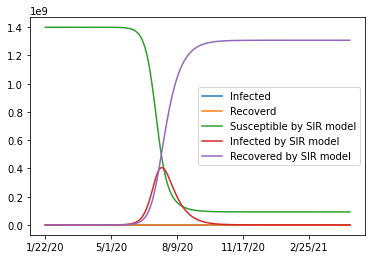

In [4]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_{}_global.csv'

confirmed_cases = pd.read_csv(url.format('confirmed'))
confirmed_cases = confirmed_cases[confirmed_cases['Country/Region'] == COUNTRY]

death_cases = pd.read_csv(url.format('deaths'))
death_cases = death_cases[death_cases['Country/Region'] == COUNTRY]              
recorvered_cases = pd.read_csv(url.format('recovered'))
recorvered_cases = recorvered_cases[recorvered_cases['Country/Region'] == COUNTRY]              
if (not len(death_cases) or not len(confirmed_cases) or not len(recorvered_cases)):
    md("No record found for provided country '{}'".format(COUNTRY))
    raise RuntimeError("No record found for provided country '{}'".format(COUNTRY))
                          
# Filter out the global covid-19 cases by targeted country
# Right now, I am choosing Feb. 28 2021 as the hard date since this is when mrna vaccination started
# '1/22/2020' is the date of the first report
start_date = '1/22/20'
end_date = '4/28/21'

confirmed = confirmed_cases.iloc[0].loc[:end_date][4:]
deaths = death_cases.iloc[0].loc[:end_date][4:]
recovered = recorvered_cases.iloc[0].loc[:end_date][4:]

infected = confirmed - deaths - recovered

# SIR model simulation.
INIT_S = 1400000000.0
INIT_I = 1.  # need one person to start the spread of disease
INIT_R = 0. # no one recovered
BETA = 0.2 # only parameter that need to be adjusted
GAMMA = 0.07 # it normally takes about 14 days for a person to recover, thus beta = 1/14 = 0.07
DT = 1
TN = len(confirmed) - 1

R0 = BETA/GAMMA
TR = 1.0/GAMMA

s, i, r, t = sor_model(s_0=INIT_S, i_0=INIT_I, r_0=INIT_R, 
                         beta=BETA, gamma=GAMMA, t_n=TN, dt=DT)

df = pd.DataFrame({
            'Infected': infected.values,
            'Recoverd': recovered.values,
            'Susceptible by SIR model': s,
            'Infected by SIR model': i,
            'Recovered by SIR model': r
        }, index=infected.index)
df.plot()


In [6]:
confirmed_cases.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,11/2/21,11/3/21,11/4/21,11/5/21,11/6/21,11/7/21,11/8/21,11/9/21,11/10/21,11/11/21
58,Anhui,China,31.8257,117.2264,1,9,15,39,60,70,...,1008,1008,1008,1008,1008,1008,1008,1008,1008,1008
59,Beijing,China,40.1824,116.4142,14,22,36,41,68,80,...,1173,1173,1173,1173,1174,1175,1176,1177,1179,1183
60,Chongqing,China,30.0572,107.8740,6,9,27,57,75,110,...,608,609,609,609,609,610,610,610,610,610
61,Fujian,China,26.0789,117.9874,1,5,10,18,35,59,...,1308,1308,1308,1311,1312,1313,1314,1314,1314,1315
62,Gansu,China,35.7518,104.2861,0,2,2,4,7,14,...,327,329,334,336,338,340,344,344,344,344


In [5]:
df.head()


,Infected,Recoverd,Susceptible by SIR model,Infected by SIR model,Recovered by SIR model
1/22/20,1,0,1.400000e+09,1.000000,0.000000
1/23/20,9,0,1.400000e+09,1.130000,0.070000
1/24/20,15,0,1.400000e+09,1.276900,0.149100
1/25/20,39,0,1.400000e+09,1.442897,0.238483
1/26/20,60,0,1.400000e+09,1.630474,0.339486


Based on the graph above, we can see that:
* Actual Infected population doesn't match well with the SIR model.
* Actual recovered population curve comes later than expected but becomes a lot sharper than expected.
* The current model is not good enough for give country. A lot more modifications in the algorithm is required.


# References
[1] A Simple Example of a Mathematical Model: The Spread of an Infectious Disease. *Torkel Loman*, https://www.pathsense.eu/simple-example-mathematical-model-spread-infectious-disease/

[2] Data Source: Center for Systems Science and Engineering (CSSE) at Johns Hopkins University, https://github.com/CSSEGISandData
